In [1]:
# importing our functions
from utilities import coords_to_bins, add_previous_event_time, add_possession_duration, add_total_time
#%pip install xgboost
#%pip install tabulate
# Importing  libraries
import xgboost as xgb
import numpy as np 
import pandas as pd
import seaborn as sns
import json
#Plotting
import matplotlib.pyplot as plt
#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
# Importing the libraries required for logistic regression , random forests  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, brier_score_loss
# Loading required libraries for cross validation 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score


from tabulate import tabulate
from scipy.stats import norm

In [2]:
# load data - store it in train dataframe

# Loading data for the English League
with open('events_England.json') as f:
    data_England = json.load(f)

# Converting the laoded into datframe
event_England = pd.DataFrame(data_England)
event_England['score_17_18'] = 79.605

event_England



,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409,79.605
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232,79.605
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410,79.605
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234,79.605


In [3]:
# Loading data for the English League
with open('events_Spain.json') as f:
    data_Spain = json.load(f)

# Converting the laoded into datframe
event_Spain = pd.DataFrame(data_Spain)
event_Spain['score_17_18'] = 106.998

event_Spain

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419,106.998
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418,106.998
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420,106.998
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421,106.998
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422,106.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998
628655,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998
628656,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998
628657,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998


In [4]:
# Loading data for the English League
with open('events_Italy.json') as f:
    data_Italy = json.load(f)

# Converting the laoded into datframe
event_Italy = pd.DataFrame(data_Italy)
event_Italy['score_17_18'] = 76.249

event_Italy

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957,76.249
1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,3.768418,85,180423958,76.249
2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,4.868265,72,180423959,76.249
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",2575959,Duel,3158,1H,8.114676,11,180423960,76.249
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",2575959,Duel,3158,1H,8.647892,11,180423961,76.249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
647367,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249
647368,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161,76.249
647369,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249
647370,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162,76.249


In [5]:
# Loading data for the English League
with open('events_Germany.json') as f:
    data_Germany = json.load(f)

# Converting the laoded into datframe
event_Germany = pd.DataFrame(data_Germany)
event_Germany['score_17_18'] = 71.427

event_Germany

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85,179896442,71.427
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85,179896443,71.427
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85,179896444,71.427
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85,179896445,71.427
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85,179896446,71.427
...,...,...,...,...,...,...,...,...,...,...,...,...,...
519402,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",15317,"[{'y': 9, 'x': 91}, {'y': 6, 'x': 90}]",2517044,Duel,2463,2H,2825.097992,11,251206867,71.427
519403,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",14804,"[{'y': 94, 'x': 10}, {'y': 95, 'x': 0}]",2517044,Duel,2451,2H,2825.519102,12,251206788,71.427
519404,1,Ground attacking duel,"[{'id': 701}, {'id': 1802}]",15317,"[{'y': 6, 'x': 90}, {'y': 5, 'x': 100}]",2517044,Duel,2463,2H,2826.053788,11,251206868,71.427
519405,8,Simple pass,[{'id': 1802}],14804,"[{'y': 95, 'x': 0}, {'y': 93, 'x': 5}]",2517044,Pass,2451,2H,2828.080925,85,251206790,71.427


In [6]:
# Loading data for the French League
with open('events_France.json') as f:
    data_France = json.load(f)

# Converting the laoded into datframe
event_France = pd.DataFrame(data_France)
event_France['score_17_18'] = 56.415

event_France

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],253784,"[{'y': 51, 'x': 50}, {'y': 46, 'x': 31}]",2500686,Pass,3799,1H,1.935181,85,176505119,56.415
1,8,High pass,[{'id': 1801}],29474,"[{'y': 46, 'x': 31}, {'y': 74, 'x': 68}]",2500686,Pass,3799,1H,3.599295,83,176505121,56.415
2,1,Air duel,"[{'id': 703}, {'id': 1801}]",253784,"[{'y': 74, 'x': 68}, {'y': 54, 'x': 72}]",2500686,Duel,3799,1H,6.827043,10,176505122,56.415
3,1,Air duel,"[{'id': 701}, {'id': 1802}]",56441,"[{'y': 26, 'x': 32}, {'y': 46, 'x': 28}]",2500686,Duel,3772,1H,6.985577,10,176505017,56.415
4,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",366760,"[{'y': 54, 'x': 72}, {'y': 55, 'x': 73}]",2500686,Duel,3799,1H,9.511272,11,176505124,56.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632802,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",405977,"[{'y': 65, 'x': 87}, {'y': 100, 'x': 100}]",2501065,Shot,19830,2H,2821.203869,100,253316980,56.415
632803,9,Save attempt,"[{'id': 101}, {'id': 1208}, {'id': 1802}]",25521,"[{'y': 0, 'x': 0}, {'y': 35, 'x': 13}]",2501065,Save attempt,3795,2H,2824.817116,91,253316978,56.415
632804,8,Simple pass,[{'id': 1801}],295761,"[{'y': 52, 'x': 50}, {'y': 47, 'x': 44}]",2501065,Pass,3795,2H,2888.383858,85,253316981,56.415
632805,8,Simple pass,[{'id': 1801}],249926,"[{'y': 47, 'x': 44}, {'y': 8, 'x': 41}]",2501065,Pass,3795,2H,2889.654402,85,253316982,56.415


In [7]:
event_data = pd.concat([event_England, event_France, event_Germany, event_Italy, event_Spain])

# Reset the index of the resulting dataframe
event_data = event_data.reset_index(drop=True)
event_data


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998
3071391,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998
3071392,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998
3071393,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998


In [8]:
event_data = add_previous_event_time(event_data)
event_data


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,previous_event_time
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,0.000000
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,2.758649
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,4.946850
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,6.542188
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,8.143395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,2824.741855
2442732,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161,76.249,2870.982660
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,2872.101142
2442734,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162,76.249,2872.990437


In [9]:
event_data = add_possession_duration(event_data)
event_data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,previous_event_time,possession_duration,team_possession
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,0.000000,2.758649,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,2.758649,2.188201,4.946850
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,4.946850,1.595338,6.542188
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,6.542188,1.601207,8.143395
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,8.143395,2.158971,10.302366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,2824.741855,46.240805,3526.553481
2442732,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161,76.249,2870.982660,1.118482,2220.624045
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,2872.101142,0.889295,3527.442776
2442734,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162,76.249,2872.990437,1.058769,2221.682814


In [10]:
event_data = add_total_time(event_data)
event_data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,previous_event_time,possession_duration,team_possession,total_time
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,0.000000,2.758649,2.758649,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,2.758649,2.188201,4.946850,4.946850
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,4.946850,1.595338,6.542188,6.542188
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,6.542188,1.601207,8.143395,8.143395
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,8.143395,2.158971,10.302366,10.302366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,2824.741855,46.240805,3526.553481,5746.059044
2442732,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161,76.249,2870.982660,1.118482,2220.624045,5747.177526
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,2872.101142,0.889295,3527.442776,5748.066821
2442734,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162,76.249,2872.990437,1.058769,2221.682814,5749.125590


In [11]:
# Calculating percentage of possession
event_data['possession_percent'] = event_data['team_possession']/event_data['total_time']
event_data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,previous_event_time,possession_duration,team_possession,total_time,possession_percent
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,0.000000,2.758649,2.758649,2.758649,1.000000
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,2.758649,2.188201,4.946850,4.946850,1.000000
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,4.946850,1.595338,6.542188,6.542188,1.000000
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,6.542188,1.601207,8.143395,8.143395,1.000000
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,8.143395,2.158971,10.302366,10.302366,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,2824.741855,46.240805,3526.553481,5746.059044,0.613734
2442732,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161,76.249,2870.982660,1.118482,2220.624045,5747.177526,0.386385
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,2872.101142,0.889295,3527.442776,5748.066821,0.613675
2442734,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162,76.249,2872.990437,1.058769,2221.682814,5749.125590,0.386438


# Filtering out all the shots from our dataset

In [12]:
# Filtering out all the shots from our dataset
shots_df = event_data[event_data['subEventName']=='Shot'].reset_index(drop=True)

shots_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,previous_event_time,possession_duration,team_possession,total_time,possession_percent
0,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,79.605,93.961235,0.634553,72.105703,94.595788,0.762251
1,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,79.605,178.317724,1.537061,104.360449,179.854785,0.580248
2,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,79.605,254.036308,0.708719,135.034698,254.745027,0.530078
3,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,79.605,423.759467,2.064568,219.635022,425.824035,0.515788
4,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,79.605,814.004042,1.457973,390.934751,815.462015,0.479403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40456,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",116269,"[{'y': 45, 'x': 95}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1152.032980,100,253566542,76.249,1151.851893,0.181087,2474.514668,4027.109364,0.614464
40457,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1212}, {'id'...",3548,"[{'y': 38, 'x': 93}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1251.730517,100,253566586,76.249,1248.911436,2.819081,2542.031272,4126.806901,0.615980
40458,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",21177,"[{'y': 46, 'x': 90}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2065.034482,100,253566910,76.249,2063.391089,1.643393,3023.610571,4940.110866,0.612053
40459,10,Shot,"[{'id': 402}, {'id': 1212}, {'id': 1802}]",349102,"[{'y': 32, 'x': 79}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2367.252041,100,253566961,76.249,2363.287131,3.964910,3234.302277,5242.328425,0.616959


In [13]:
# Let us build the required dataset for expected goal model building
# Creating your feature matrix and dropping non-essential columns
shots_model=pd.DataFrame(columns=['Goal','X','Y', 'score_17_18', 'Match_Period','possession_percent'
                                  ])

for i,shot in shots_df.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan( 7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1
       
         # Adding match half, score_teams, possession_percent
        shots_model.at[i,'Match_Period'] = shot['matchPeriod']
        shots_model.at[i,'score_17_18'] = shot['score_17_18']
        shots_model.at[i,'possession_percent'] = shot['possession_percent']
       
        
shots_model



,Goal,X,Y,score_17_18,Match_Period,possession_percent,C,Distance,Angle
0,1,12,41,79.605,1H,0.762251,9.0,13.891814,0.474451
1,0,15,52,79.605,1H,0.580248,2.0,15.803560,0.453823
3,0,19,33,79.605,1H,0.515788,17.0,22.805811,0.280597
4,0,25,30,79.605,1H,0.479403,20.0,29.292704,0.223680
5,0,10,39,79.605,1H,0.550801,11.0,12.703248,0.479051
...,...,...,...,...,...,...,...,...,...
40456,0,5,45,76.249,2H,0.614464,5.0,6.174545,0.999010
40457,0,7,38,76.249,2H,0.61598,12.0,10.717392,0.487547
40458,1,10,46,76.249,2H,0.612053,4.0,10.817116,0.638225
40459,0,21,32,76.249,2H,0.616959,18.0,24.961821,0.258795


In [14]:
# Match_Period is a categorical variable. So we will perform one-hot encoding for the column

# perform one-hot encoding for Match_Period column
one_hot = pd.get_dummies(shots_model['Match_Period'])

#merge one-hot encoded columns back with original DataFrame
shots_model = pd.concat([shots_model, one_hot], axis=1)

#drop the original 'Match_Period' column
shots_model.drop('Match_Period', axis=1, inplace=True)

# Resetting the index of the dataframe
shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model

,Goal,X,Y,score_17_18,possession_percent,C,Distance,Angle,1H,2H
0,1,12,41,79.605,0.762251,9.0,13.891814,0.474451,1,0
1,0,15,52,79.605,0.580248,2.0,15.803560,0.453823,1,0
2,0,19,33,79.605,0.515788,17.0,22.805811,0.280597,1,0
3,0,25,30,79.605,0.479403,20.0,29.292704,0.223680,1,0
4,0,10,39,79.605,0.550801,11.0,12.703248,0.479051,1,0
...,...,...,...,...,...,...,...,...,...,...
33937,0,5,45,76.249,0.614464,5.0,6.174545,0.999010,0,1
33938,0,7,38,76.249,0.61598,12.0,10.717392,0.487547,0,1
33939,1,10,46,76.249,0.612053,4.0,10.817116,0.638225,0,1
33940,0,21,32,76.249,0.616959,18.0,24.961821,0.258795,0,1


In [15]:
shots_model.dtypes

Goal                   object
X                      object
Y                      object
score_17_18            object
possession_percent     object
C                     float64
Distance              float64
Angle                 float64
1H                      uint8
2H                      uint8
dtype: object

In [16]:
shots_model = shots_model.astype({'X': float, 'Y': float, 'Goal': int, '1H': int, '2H': int, 'score_17_18': float, 'possession_percent':float})

# Again checking our datatypes
shots_model.dtypes

Goal                    int32
X                     float64
Y                     float64
score_17_18           float64
possession_percent    float64
C                     float64
Distance              float64
Angle                 float64
1H                      int32
2H                      int32
dtype: object

In [17]:
shots_model.isna().sum()

Goal                  0
X                     0
Y                     0
score_17_18           0
possession_percent    0
C                     0
Distance              0
Angle                 0
1H                    0
2H                    0
dtype: int64

In [18]:
shots_model['bins'] =coords_to_bins(shots_model, 'X', 'Y')
shots_model

,Goal,X,Y,score_17_18,possession_percent,C,Distance,Angle,1H,2H,bins
0,1,12.0,41.0,79.605,0.762251,9.0,13.891814,0.474451,1,0,14
1,0,15.0,52.0,79.605,0.580248,2.0,15.803560,0.453823,1,0,15
2,0,19.0,33.0,79.605,0.515788,17.0,22.805811,0.280597,1,0,13
3,0,25.0,30.0,79.605,0.479403,20.0,29.292704,0.223680,1,0,23
4,0,10.0,39.0,79.605,0.550801,11.0,12.703248,0.479051,1,0,13
...,...,...,...,...,...,...,...,...,...,...,...
33937,0,5.0,45.0,76.249,0.614464,5.0,6.174545,0.999010,0,1,4
33938,0,7.0,38.0,76.249,0.615980,12.0,10.717392,0.487547,0,1,3
33939,1,10.0,46.0,76.249,0.612053,4.0,10.817116,0.638225,0,1,14
33940,0,21.0,32.0,76.249,0.616959,18.0,24.961821,0.258795,0,1,23


In [19]:
shots_model.drop(['X','Y'], axis=1, inplace=True)


shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model



,Goal,score_17_18,possession_percent,C,Distance,Angle,1H,2H,bins
0,1,79.605,0.762251,9.0,13.891814,0.474451,1,0,14
1,0,79.605,0.580248,2.0,15.803560,0.453823,1,0,15
2,0,79.605,0.515788,17.0,22.805811,0.280597,1,0,13
3,0,79.605,0.479403,20.0,29.292704,0.223680,1,0,23
4,0,79.605,0.550801,11.0,12.703248,0.479051,1,0,13
...,...,...,...,...,...,...,...,...,...
33937,0,76.249,0.614464,5.0,6.174545,0.999010,0,1,4
33938,0,76.249,0.615980,12.0,10.717392,0.487547,0,1,3
33939,1,76.249,0.612053,4.0,10.817116,0.638225,0,1,14
33940,0,76.249,0.616959,18.0,24.961821,0.258795,0,1,23


# First model : Logestic Regression

In [20]:
# Creating a dataframe containing all the features
X = shots_model[['C','score_17_18', '2H' ,'Distance','Angle','possession_percent']]
# Feature data set
X

,C,score_17_18,2H,Distance,Angle,possession_percent
0,9.0,79.605,0,13.891814,0.474451,0.762251
1,2.0,79.605,0,15.803560,0.453823,0.580248
2,17.0,79.605,0,22.805811,0.280597,0.515788
3,20.0,79.605,0,29.292704,0.223680,0.479403
4,11.0,79.605,0,12.703248,0.479051,0.550801
...,...,...,...,...,...,...
33937,5.0,76.249,1,6.174545,0.999010,0.614464
33938,12.0,76.249,1,10.717392,0.487547,0.615980
33939,4.0,76.249,1,10.817116,0.638225,0.612053
33940,18.0,76.249,1,24.961821,0.258795,0.616959


In [21]:
# Scaling the numeric continous features in our data set
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_continuous = X[['C', 'Distance', 'Angle','score_17_18','possession_percent']] # select only continuous columns
X_scaled = scaler.fit_transform(X_continuous)

X_scaled

array([[-0.43355223, -0.73871869,  0.44413802,  0.09604288,  3.27691811],
       [-1.33526891, -0.50239097,  0.35154924,  0.09604288,  0.86309688],
       [ 0.59698112,  0.363219  , -0.42597354,  0.09604288,  0.0081883 ],
       ...,
       [-1.07763557, -1.11880923,  1.17923267, -0.10882706,  1.28491074],
       [ 0.72579779,  0.62974242, -0.52383144, -0.10882706,  1.34997604],
       [-0.69118557, -1.38740247,  1.54677137, -0.10882706,  1.3016219 ]])

In [22]:
# Dropping the original continuous columns in the dataframe
X = X.drop(['C','Angle','Distance','score_17_18','possession_percent'], axis=1)

# Adding scaled columns to our dataset
X['C'] = X_scaled[:,0]
X['Distance'] = X_scaled[:,1]
X['Angle'] = X_scaled[:,2]
X['score_17_18'] = X_scaled[:,3]
X['possession_percent'] = X_scaled[:,4]



# Finalized Feature Dataset
X

,2H,C,Distance,Angle,score_17_18,possession_percent
0,0,-0.433552,-0.738719,0.444138,0.096043,3.276918
1,0,-1.335269,-0.502391,0.351549,0.096043,0.863097
2,0,0.596981,0.363219,-0.425974,0.096043,0.008188
3,0,0.983431,1.165121,-0.681446,0.096043,-0.474377
4,0,-0.175919,-0.885648,0.464784,0.096043,0.472548
...,...,...,...,...,...,...
33937,1,-0.948819,-1.692718,2.798606,-0.108827,1.316888
33938,1,-0.047102,-1.131137,0.502919,-0.108827,1.336993
33939,1,-1.077636,-1.118809,1.179233,-0.108827,1.284911
33940,1,0.725798,0.629742,-0.523831,-0.108827,1.349976


In [23]:
# Creating a data set containing dependent variable 'Goal'
y = shots_model['Goal']

y

0        1
1        0
2        0
3        0
4        0
        ..
33937    0
33938    0
33939    1
33940    0
33941    0
Name: Goal, Length: 33942, dtype: int32

# First model : Logistic Regression

In [24]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22835
Goals in Training Data:  2621


In [26]:
# calculation of weight_0 and weight_1
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.8970380263984915
Weight of Goal Class in Training:  0.10296197360150848


In [27]:
param_grid_lr = {'C': [0.1, 1, 10, 100],
              'penalty': ['l2'],
              'class_weight': ['balanced', {0:weight_0, 1:weight_1}]}

In [28]:
# Defining the outer loop for train-test split
# This code defines the outer loop for cross-validation using StratifiedKFold(). 
# n_splits is the number of folds to use, and shuffle is whether or not to shuffle the data before splitting

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Defining the inner loop for cross-validation on the training set
# This loop will be used to perform cross-validation on the training set for each combination of hyperparameters.
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
# Defining the logistic regression model
LR_model = LogisticRegression()
# Starting the tiemr
start_time = time.time()

# Perform nested cross-validation with grid search

grid = GridSearchCV(LR_model, param_grid=param_grid_lr, cv=cv_inner, scoring='f1', n_jobs=-1)
scores = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

# the array of F1-scores obtained by performing cross-validation on the training set using the GridSearchCV object
scores

array([0.33135555, 0.35555556, 0.35637047, 0.351414  , 0.34482759])

In [30]:
grid.fit(X_train, y_train)
best_lr_model = grid.best_estimator_

# Stopping the timer
end_time = time.time()

lr_training_time = end_time - start_time

# Print the best parameters and training time
print("Best parameters: ", grid.best_params_)
print ("Model Training Time: {:.3f} seconds".format(lr_training_time))

Best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Model Training Time: 20.646 seconds


In [31]:
# Model Summary
# Get the estimated coefficients
coef = best_lr_model.coef_[0]
intercept = best_lr_model.intercept_[0]

# Calculate the standard errors
n = len(y_train)
A = np.hstack((np.ones((n, 1)), X_train))
p = len(coef)
y_pred = best_lr_model.predict(X_train)
residuals = y_train - y_pred
sigma2 = np.sum(residuals**2) / (n - p - 1)
cov = sigma2 * np.linalg.inv(np.dot(A.T, A))
se = np.sqrt(np.diag(cov)[1:])

# Calculate the Wald statistics and p-values
wald = coef / se
p_values = (1 - norm.cdf(np.abs(wald))) * 2

features = list(X_train.columns)

# Create a summary table of coefficients, standard errors, Wald statistics, and p-values
table = np.column_stack((features, coef, se, wald, p_values))
headers = ['Feature', 'Coef.', 'Std. Err.', 'Wald', 'p-value']
print(tabulate(table, headers=headers))

Feature                  Coef.    Std. Err.       Wald    p-value
------------------  ----------  -----------  ---------  ---------
2H                   0.174042    0.00658004    26.45            0
C                   -0.0606014   0.00381626   -15.8798          0
Distance            -0.759123    0.00459696  -165.136           0
Angle                0.443637    0.00504436    87.9472          0
score_17_18         -0.0423104   0.00326173   -12.9718          0
possession_percent   0.0394986   0.00327116    12.0748          0


In [32]:
#Brier score for Linear Regression on training data
LR_BRS_train = brier_score_loss(y_train, best_lr_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (classification_report(y_train, best_lr_model.predict(X_train)), LR_BRS_train, end=  " is the Brier score on testing data ")

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     22835
           1       0.23      0.71      0.35      2621

    accuracy                           0.73     25456
   macro avg       0.59      0.72      0.59     25456
weighted avg       0.88      0.73      0.78     25456
 0.18350115165551645 is the Brier score on testing data 

In [33]:
# Classfication report for training data
y_pred = best_lr_model.predict(X_test)
LR_BRS_test = brier_score_loss(y_test, best_lr_model.predict_proba(X_test)[:, 1])
print (classification_report(y_test, y_pred),  LR_BRS_test, end=  " is the brier score on testing data ")

              precision    recall  f1-score   support

           0       0.96      0.73      0.83      7654
           1       0.22      0.70      0.34       832

    accuracy                           0.73      8486
   macro avg       0.59      0.71      0.58      8486
weighted avg       0.88      0.73      0.78      8486
 0.18468814142021805 is the brier score on testing data 

# Second Model : Xgboost

In [34]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
xgb_model = xgb.XGBClassifier()
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22835
Goals in Training Data:  2621


In [36]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
scale_pos_weight

8.712323540633346

In [37]:
# Defining the hyper-parameter grid for XG Boost
param_grid_xgb = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [5, 7, 9],
              'n_estimators': [100, 200, 300],
              'scale_pos_weight': [1, scale_pos_weight]}

In [38]:
# starting the timer

start_time = time.time()

# Perform nested cross-validation with grid search
grid_xg = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_xg = cross_val_score(grid_xg, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)
# Fit the best model on the entire training set
grid_xg.fit(X_train, y_train)
best_xgb_model = grid_xg.best_estimator_

# Stopping the timer
stop_time = time.time()

# Training Time
xgb_training_time = stop_time - start_time

In [39]:
# Print the best parameters and training time
print("Best parameters: ", grid_xg.best_params_)
print ("Model Training Time: {:.3f} seconds".format(xgb_training_time))

Best parameters:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 8.712323540633346}
Model Training Time: 833.387 seconds


In [40]:
 #Brier score for xgboost on training data
xgb_BRS_train = brier_score_loss(y_train, best_xgb_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (classification_report(y_train, best_xgb_model.predict(X_train)), xgb_BRS_train, end=  " is the brier score on training data")

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     22835
           1       0.24      0.75      0.36      2621

    accuracy                           0.72     25456
   macro avg       0.60      0.74      0.59     25456
weighted avg       0.89      0.72      0.78     25456
 0.17982604513912603 is the brier score on training data

In [41]:
# On testing data
y_pred_xgb = best_xgb_model.predict(X_test)
xgb_BRS_test = brier_score_loss(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

print (classification_report(y_test, y_pred_xgb), xgb_BRS_test , end= " is the brier score on test data")

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      7654
           1       0.22      0.72      0.34       832

    accuracy                           0.72      8486
   macro avg       0.59      0.72      0.58      8486
weighted avg       0.89      0.72      0.78      8486
 0.18306229110013794 is the brier score on test data

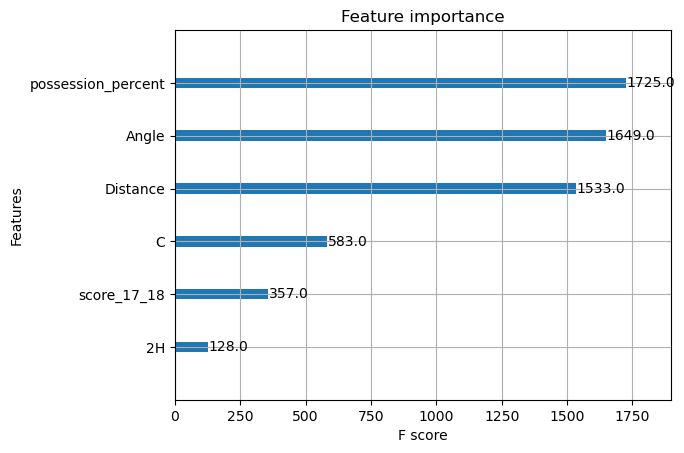

In [42]:
# Plottingg important features
# Plot feature importance
xgb.plot_importance(best_xgb_model)
plt.show()

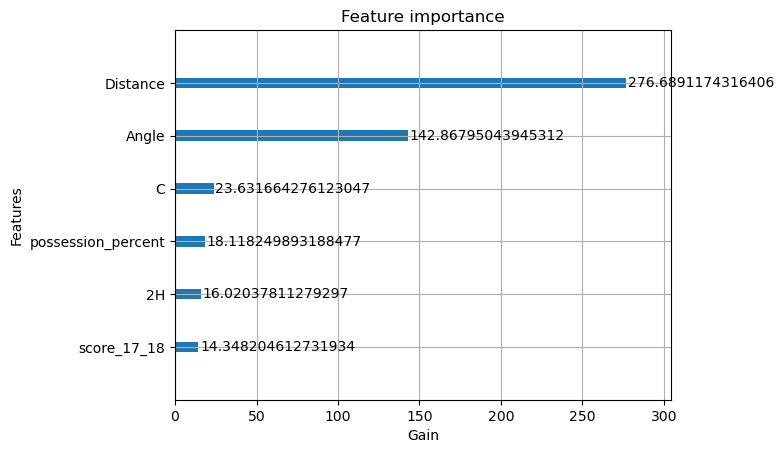

In [43]:
#We can also plot feature importance using two parameters:
# 1)gain: the 'gain' option displays the average gain of each feature when it is used in a tree

xgb.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain')
plt.show()

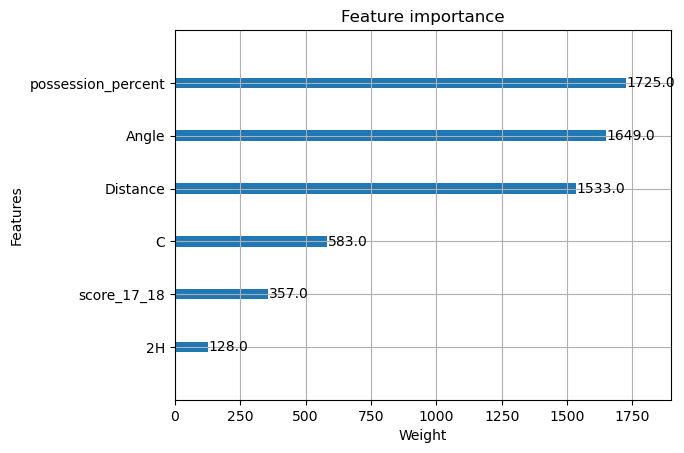

In [44]:
# 2)weight: The 'weight' option displays the number of times each feature appears in a tree

xgb.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight')
plt.show()

# Third Model : Random Forest

In [45]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [46]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.8970380263984915
Weight of Goal Class in Training:  0.10296197360150848


In [47]:
# Define the hyperparameters to tune
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [7, 9, 12, 15, 17],
              'min_samples_split': [3, 5, 10],
              'class_weight': ['balanced', {0: weight_0, 1: weight_1}]}

In [48]:
# Define the random forest model
rf_model = RandomForestClassifier()
start_time = time.time()
# Perform nested cross-validation with grid search
grid_rf = GridSearchCV(rf_model, param_grid=param_grid, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_rf = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

In [49]:
# Fit the best model on the entire training set
grid_rf.fit(X_train, y_train)
best_rf_model = grid_rf.best_estimator_

end_time = time.time()

rf_training_time = end_time - start_time

In [50]:
# Print the best parameters
print("Best parameters: ", grid_rf.best_params_)
print ("Model Training Time: {:.3f} seconds".format(rf_training_time))

Best parameters:  {'class_weight': 'balanced', 'max_depth': 12, 'min_samples_split': 3, 'n_estimators': 100}
Model Training Time: 1034.439 seconds


In [51]:
# Brier score on training data
rf_brs_train = brier_score_loss(y_train, best_rf_model.predict_proba(X_train)[:, 1])
# Classfication report for training data and brier score
print (classification_report(y_train, best_rf_model.predict(X_train)),rf_brs_train, end= " is the brier score on training data" )

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     22835
           1       0.41      0.83      0.55      2621

    accuracy                           0.86     25456
   macro avg       0.69      0.85      0.73     25456
weighted avg       0.92      0.86      0.88     25456
 0.09974352777331916 is the brier score on training data

In [52]:
# Evaluate the performance of the best model on the testing set
y_pred_rf = best_rf_model.predict(X_test)
# Classfication report and brier score  for testing data
rf_brs_test = brier_score_loss(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print (classification_report(y_test, y_pred_rf), rf_brs_test, end= " is the brier score on testing data")

              precision    recall  f1-score   support

           0       0.94      0.84      0.88      7654
           1       0.25      0.52      0.34       832

    accuracy                           0.80      8486
   macro avg       0.60      0.68      0.61      8486
weighted avg       0.87      0.80      0.83      8486
 0.12856088342233754 is the brier score on testing data

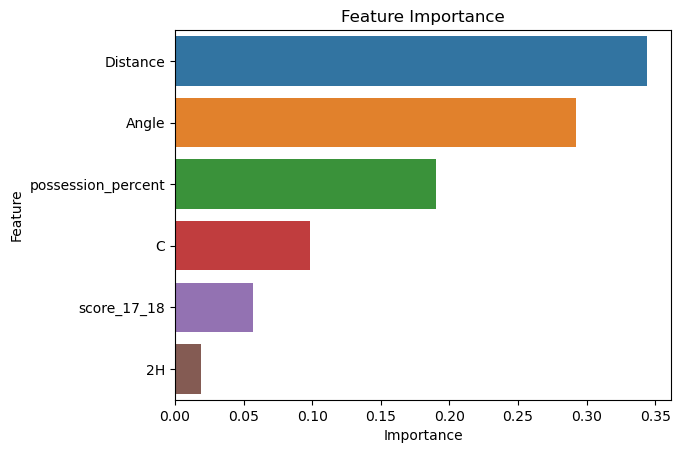

In [53]:
# Extract feature importances
importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Create barplot using seaborn
sns.barplot(x=importances[indices], y=names)

# Add x and y axis labels
plt.xlabel("Importance")
plt.ylabel("Feature")

# Show plot
plt.show()

In [54]:
# Precision scores for the four models on training data
prec_lr_train = precision_score(y_train, best_lr_model.predict(X_train))

prec_xgb_train = precision_score(y_train, best_xgb_model.predict(X_train))

prec_rf_train = precision_score(y_train, best_rf_model.predict(X_train))

#prec_svm_train = precision_score(y_train, best_svm_model.predict(X_train))

prec_train = [prec_lr_train, prec_xgb_train, prec_rf_train]

# Precision scores for the four models on testing data
prec_lr_test = precision_score(y_test, y_pred)

prec_xgb_test = precision_score(y_test, y_pred_xgb)

prec_rf_test = precision_score(y_test, y_pred_rf)

#prec_svm_test = precision_score(y_test, y_pred_svm)

prec_test = [prec_lr_test, prec_xgb_test, prec_rf_test]

# Recall scores for the four models on training data
rec_lr_train = recall_score(y_train, best_lr_model.predict(X_train))

rec_xgb_train = recall_score(y_train, best_xgb_model.predict(X_train))

rec_rf_train = recall_score(y_train, best_rf_model.predict(X_train))

#rec_svm_train = recall_score(y_train, best_svm_model.predict(X_train))

rec_train = [rec_lr_train, rec_xgb_train, rec_rf_train]


# Calculting Recall for the four models on test data
rec_lr_test = recall_score(y_test, y_pred)

rec_xgb_test = recall_score(y_test, y_pred_xgb)

rec_rf_test = recall_score(y_test, y_pred_rf)

#rec_svm_test = recall_score(y_test, y_pred_svm)

rec_test = [rec_lr_test, rec_xgb_test, rec_rf_test]

# Accuracy scores for the four models on training data
acc_lr_train = accuracy_score(y_train, best_lr_model.predict(X_train))

acc_xgb_train = accuracy_score(y_train, best_xgb_model.predict(X_train))

acc_rf_train = accuracy_score(y_train, best_rf_model.predict(X_train))

#acc_svm_train = accuracy_score(y_train, best_svm_model.predict(X_train))

acc_train = [acc_lr_train, acc_xgb_train, acc_rf_train]

# Calculating Accuracy for the four models on test data
acc_lr_test = accuracy_score(y_test, y_pred)

acc_xgb_test = accuracy_score(y_test, y_pred_xgb)

acc_rf_test = accuracy_score(y_test, y_pred_rf)

#acc_svm_test = accuracy_score(y_test, y_pred_svm)

acc_test = [acc_lr_test, acc_xgb_test, acc_rf_test]
# Brier score for four models on training data
BRS_train = [LR_BRS_train, xgb_BRS_train, rf_brs_train]
# Brier score for four models on test data
BRS_test = [LR_BRS_test, xgb_BRS_test, rf_brs_test]


# Model training time
train_time =[lr_training_time/60, xgb_training_time/60, rf_training_time/60]

In [55]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['Logistic Regression','XG Boost','Random Forests'],
                          'Training Accuracy': acc_train, 'Training Precision': prec_train,'Training Recall':rec_train,'Training Brier': BRS_train,
                          'Testing Accuracy': acc_test, 'Testing Precision': prec_test,'Testing Recall':rec_test, 'Testing Brier': BRS_test,
                          'Training Time (mins)': train_time})

summary_df.set_index('Model Name', inplace=True)
# Displaying summary of results
summary_df.style.format(precision =3).highlight_max(color='cyan').set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'purple'}).highlight_min(color='yellow')

,Training Accuracy,Training Precision,Training Recall,Training Brier,Testing Accuracy,Testing Precision,Testing Recall,Testing Brier,Training Time (mins)
Model Name,,,,,,,,,
Logistic Regression,0.729,0.232,0.708,0.184,0.729,0.221,0.696,0.185,0.344
XG Boost,0.723,0.235,0.752,0.180,0.723,0.221,0.724,0.183,13.890
Random Forests,0.858,0.407,0.831,0.100,0.804,0.254,0.517,0.129,17.241
